# Optimizing Landscape Reconstruction
*Oliver Cheng, Zosia Adamska, Megan Engel*

This notebook is a brief example on how to use the `barrier_crosing` module in order to iteratively reconstruct a free energy landscape from the dynamics of a Brownian particle pulled by a harmonic trap moving according to a bespoke protocol. This library implements Hummer & Szabo's Free Energy Landscape Reconstruction method (2001) on arbitrary work + position data.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import jax.random as random
import jax.numpy as jnp
import matplotlib.pyplot as plt
# Barrier Crossing Imports

import barrier_crossing.models as bcm
import barrier_crossing.plotting as plotting
import importlib

I0000 00:00:1738437106.563159  149943 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


KeyboardInterrupt: 

We start by simulating a brownian particle on a double well landscape.

In [ ]:
p = importlib.import_module("figures.param_set.double_well.params_40kt")
param_set = p.param_set
param_set

SCParameters(N=1, dim=1, shift=<function free.<locals>.shift_fn at 0x14f81952d120>, mass=1e-17, temperature=4.183, gamma=950681818181.8181, beta=0.2390628735357399, init_position_fwd=Array([[-10.]], dtype=float32), init_position_rev=Array([[10.]], dtype=float32), k_s=1.0, end_time=3e-05, dt=2e-07, Neq=1000, D=440000.0, x_m=10.0, delta_E=0.0, kappa_l=0.8579884248340429, kappa_r=0.8579884248340429)

In [ ]:
energy_fn = param_set.energy_fn() # Double well potential
position_schedule = bcm.ScheduleModel(param_set, init_pos = -10, final_pos = 10.) # Creates a linear schedule from -10 to 10.
key = random.PRNGKey(1001)

<Axes:>

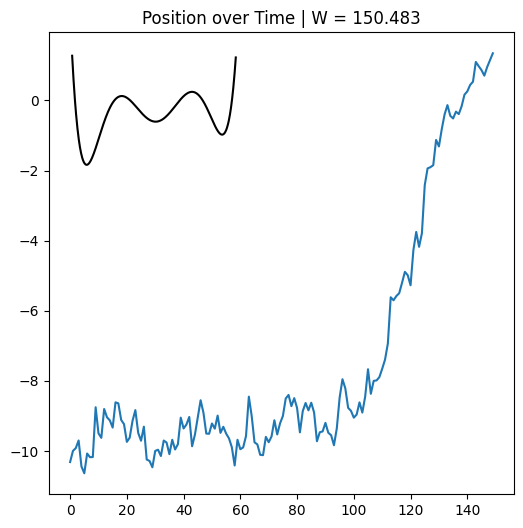

In [28]:
key, _ = random.split(key)
positions, log_prob, works = param_set.simulate_fn(position_schedule, ks_trap_fn = False, key = key, regime = "brownian")

fig = plt.figure(figsize = (6,6))
plt.plot(positions.reshape(-1))
plt.title(f"Position over Time | W = {jnp.sum(works):.3f}")
plotting.add_energy_fn_plot(param_set, fig = fig)

# Optimize Schedule With JAX-MD Autodiff

In [25]:
import barrier_crossing.train as bct
import barrier_crossing.iterate_landscape as bcla
import barrier_crossing.loss as loss
loss = importlib.reload(loss)
import optax

position_schedule = bcm.ScheduleModel(param_set, init_pos = -10, final_pos = 10.)
stiffness_schedule = bcm.ScheduleModel(param_set, init_pos = 1.0, final_pos = 1.0)
joint_schedule = bcm.JointModel(param_set, position_schedule, stiffness_schedule)

batch_size = 1000 # Number of simultaneous simulations to run
num_epochs = 300 

learning_rate = optax.exponential_decay(0.1, num_epochs, 0.5, end_value = 0.001)
optimizer = optax.adam(learning_rate)

auto_diff_simulate_fn = lambda pos_trap, stiff_trap, key: param_set.simulate_fn(pos_trap, stiff_trap, key = key)

grad_fn = lambda N: loss.estimate_gradient_work(N, auto_diff_simulate_fn, joint_schedule, reg = 1.)

losses = bct.train(joint_schedule, optimizer, grad_fn, key, batch_size, num_epochs)
coeffs = joint_schedule.coef_hist

Optimize Protocol:  18%|██████████████▏                                                                 | 53/300 [00:39<03:03,  1.35it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'Epochs')

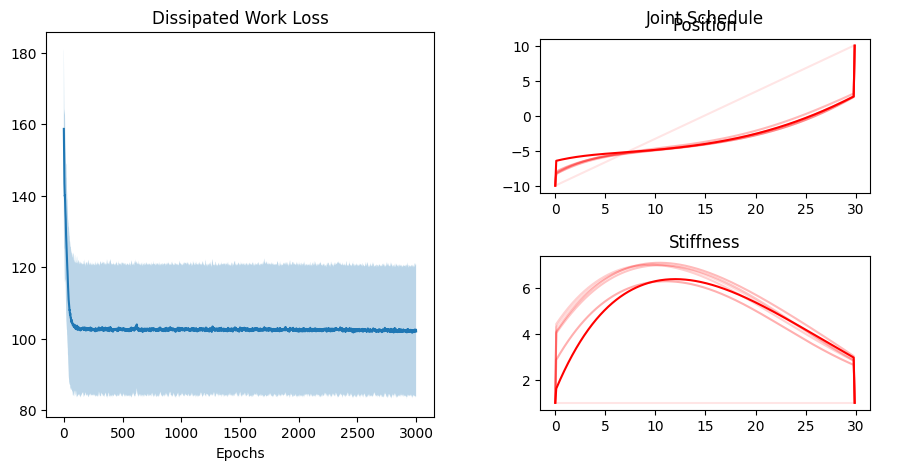

In [18]:
_, (loss_ax, protocol_ax) = plt.subplots(1, 2, figsize = (11,5))

plotting.plot_evolving(ax = protocol_ax, model = joint_schedule, color = "red")
protocol_ax.set_title("Joint Schedule")
protocol_ax.set_xlabel("Timestep")

plotting.plot_with_stdev(losses, ax = loss_ax, axis = 1)
loss_ax.set_title("Dissipated Work Loss")
loss_ax.set_xlabel("Epochs")

# Reconstructions
This package implements Hummer & Szabo's Single-Molecule Free Energy Landscape Reconstruction formula about a reaction coordinate.

Reconstructing with Linear protocol:   0%|                                                                             | 0/20 [00:00<?, ?it/s]

Reconstructing with Position Optimized protocol: 100%|████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.06it/s]


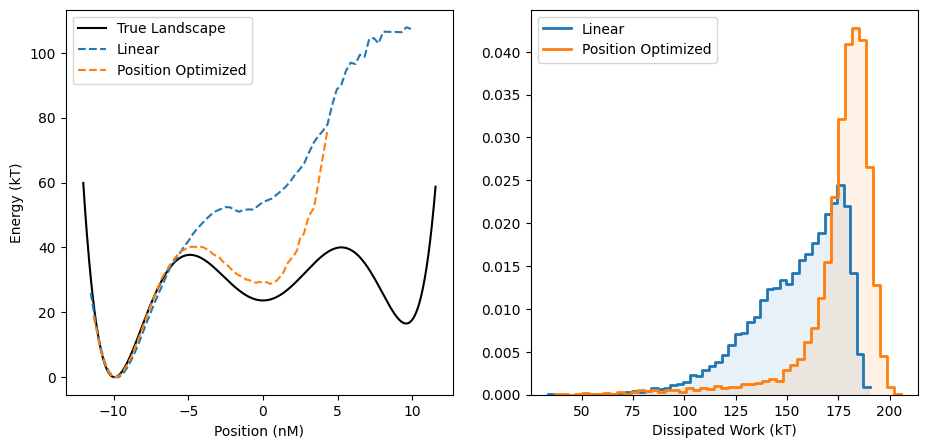

In [19]:
import barrier_crossing.simulate as bcs
import barrier_crossing.iterate_landscape as bcla
from tqdm import tqdm

_, (ax_landscape, ax_hist) = plt.subplots(1,2, figsize = (11, 5))
batch_size = 1000
bins = 70
num_reconstructions = 20

protocols = {
    "Linear": [position_schedule.protocol(position_schedule.coef_hist[0]), lambda key: param_set.simulate_fn(position_schedule.protocol(position_schedule.coef_hist[0]), ks_trap_fn = False, key = key, regime = "brownian")
], 
    "Position Optimized": [joint_schedule, lambda key: param_set.simulate_fn(*joint_schedule.models, key = key, regime = "brownian")]
}

reconstructed_landscapes = []
reconstructed_labels = []
for protocol_type, (position_protocol, no_key_simulate_fn) in protocols.items():
    energies = []
    for _ in tqdm(range(num_reconstructions), desc = f"Reconstructing with {protocol_type} protocol"):
        key, split = random.split(key)
        
        # Run `batch_size` simulations vectorized.
        _, (trajectories, works, _) = bcs.batch_simulate_harmonic(batch_size, no_key_simulate_fn, key)
        if isinstance(position_protocol, bcm.JointModel):
            protocols = position_protocol.models
        else:
            protocols = (position_protocol,
                        param_set.k_s)
        midpoints, E = bcla.energy_reconstruction(
                        jnp.cumsum(works, axis=1), 
                        trajectories, 
                        bins, 
                        *protocols,
                        param_set.simulation_steps, 
                        batch_size, 
                        param_set.beta)

        energies.append(E)
    energies = bcla.interpolate_inf(jnp.mean(jnp.array(energies), axis = 0))
    
    reconstructed_landscapes.append([midpoints, energies])
    reconstructed_labels.append(protocol_type)
    
plotting.plot_landscapes(param_set, reconstructed_landscapes, reconstructed_labels, ax = ax_landscape)
plotting.add_axes("landscape", ax = ax_landscape)
ax_landscape.legend()

true_models = [position_schedule.clone(coef) for coef in [position_schedule.coef_hist[0], position_schedule.coef_hist[-1]]]
plotting.plot_hists(ax = ax_hist, labels = reconstructed_labels, models = true_models)
ax_hist.legend()
plotting.add_axes("hist", ax = ax_hist)


# Iterative Landscape Reconstruction
In real life examples such as in hairpin pulling experiments, the true underlying free energy landscape is unknown, and we seek to understand the landscape through experiment. Below implements the iterative method whereby protocols are optimized with brownian particle simulations on top of "guesses" of landscapes, which are reconstructed from trajectory data of MD simulations or real pulling experiments.

The implementation of this procedure requires three components:
1. Two simulators: one which simulates under an arbitrary Hamiltonian for which we are attempting to find the free energy landscape of, and another which will simulate a brownian particle in "guess" of the landscape. The second simulator must be autodifferentiable in order to learn a bespoke schedule.
2. A reconstructor: This package implements Hummer & Szabo's method which adapts the Weighted Histogram Analysis Method (WHAM) to recover free energy estimates across a landscape using simulation trajectories.
3. A trainer: by backpropagating gradients through the molecular dynamics simulator, the trainer uses gradient descent to learn a schedule which minimizes a loss (dissipated work or Jarzynski Error).

In [9]:
# We train a joint model, optimizing both position and stiffness simultaneously, which should perform the best.
bcla = importlib.reload(bcla)
opt_batch_size = 3000
opt_steps_landscape = 3000
max_iter = 3
position_schedule = bcm.ScheduleModel(param_set, init_pos = -10, final_pos = 10.)
stiffness_schedule = bcm.ScheduleModel(param_set, init_pos = 1.0, final_pos = 1.0)
joint_schedule = bcm.JointModel(param_set, position_schedule, stiffness_schedule)

true_simulation_fwd = lambda trap_fn, ks_fn: lambda keys: p.param_set.simulate_fn(
  trap_fn, 
  ks_fn,
  keys, 
  regime = "brownian",
  fwd = True)

sim_no_E = lambda energy_fn: lambda trap_fn, ks_fn, keys: p.param_set.simulate_fn(
  trap_fn, 
  ks_fn,
  keys, 
  regime = "brownian",
  fwd = False,
  custom = energy_fn)

reconstruct_fn = lambda batch_works, trajectories, position_fn, stiffness_fn, batch_size: \
  bcla.energy_reconstruction(batch_works, 
                            trajectories, 
                            bins, 
                            position_fn, 
                            stiffness_fn, 
                            param_set.simulation_steps,
                            batch_size, 
                            param_set.beta)

grad_no_E = lambda model, simulate_fn: lambda num_batches: loss.estimate_gradient_work(
    num_batches,
    simulate_fn,
    model, reg= 0.1)

train_fn = lambda model, grad_fn, key: bct.train(model, optimizer, grad_fn, key, batch_size = opt_batch_size, num_epochs = opt_steps_landscape)

it_landscapes, it_coeffs, losses = bcla.optimize_landscape(
  max_iter,
  batch_size,
  joint_schedule,
  true_simulation_fwd,
  sim_no_E,
  grad_no_E,
  reconstruct_fn,
  train_fn,
  key,
  num_reconstructions = 30)

Optimize Landscape:   0%|                                                                                               | 0/3 [00:00<?, ?it/s]

Infinities found in energy reconstruction. Continuing through interpolation...


Optimize Landscape:   0%|                                                                                               | 0/3 [04:26<?, ?it/s]


KeyboardInterrupt: 

Optimize Landscape: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [20:50<00:00, 416.81s/it]


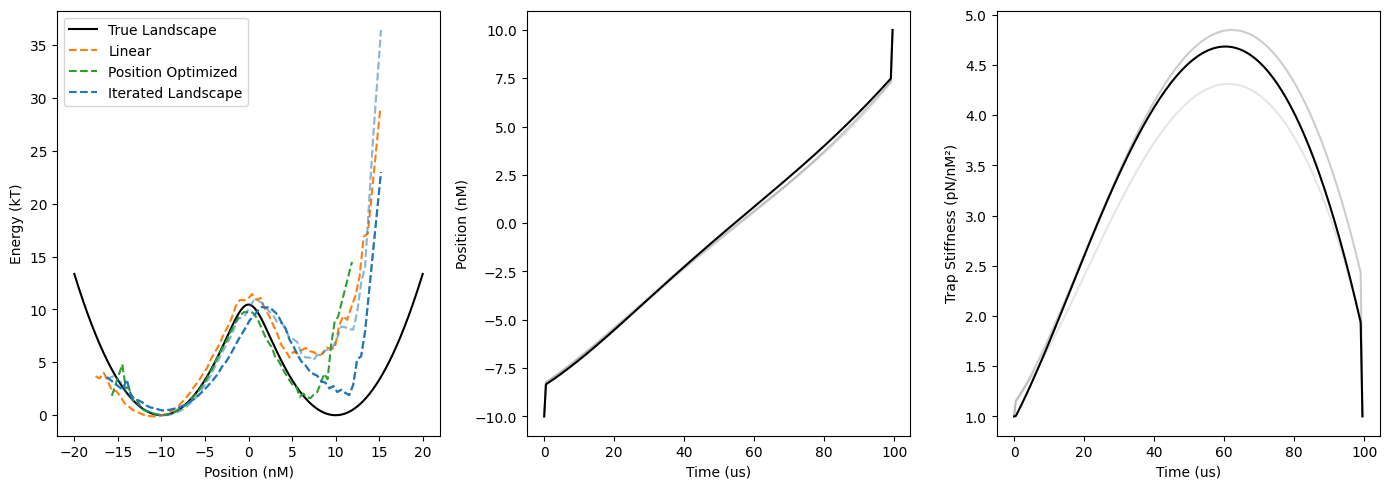

In [ ]:


fig, (ax_landscapes, ax_position, ax_stiffness) = plt.subplots(1,3, figsize = (14,5))

energies = jnp.array([landscape[1] for landscape in it_landscapes])

HALF = it_coeffs[0].shape[0]//2
position_coeffs = [coef[:HALF] for coef in it_coeffs]
stiffness_coeffs = [coef[HALF:] for coef in it_coeffs]
plotting.plot_evolving(ax = ax_position, model = position_schedule, coeffs = position_coeffs, num = max_iter)
plotting.add_axes("schedule_position", ax = ax_position)

plotting.plot_evolving(ax = ax_stiffness, model = stiffness_schedule, coeffs = stiffness_coeffs, num = max_iter)
plotting.add_axes("schedule_stiffness", ax = ax_stiffness)

plotting.plot_landscapes(param_set, ax = ax_landscapes, landscapes = [it_landscapes] + reconstructed_landscapes, labels = ["Iterated Landscape"] + reconstructed_labels, iterated_index = 0)
plotting.add_axes("landscape", ax = ax_landscapes)

ax_landscapes.legend()
plt.tight_layout()

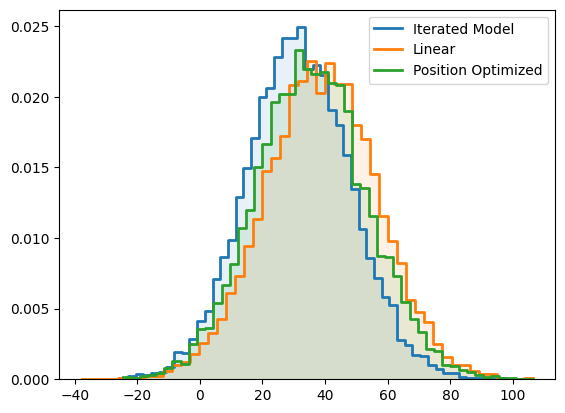

In [ ]:
plotting.plot_hists([joint_schedule] + true_models, ["Iterated Model"] + reconstructed_labels)
plt.legend()